## Using Ponder for Healthcare Data Analysis

With the growth of electronic health records, healthcare providers store, process, and analyze information about patients, their medical history, treatment, and outcomes. Effective analysis of electronic health records has shown to improve the patient care experience, support clinical decision-making, and advance the frontiers of medical research.

In this post, we will walk through a real-world analysis scenario of how you can use Ponder to analyze electronic health records directly in your data warehouse. You can download the notebook associated with this post [here](https://github.com/ponder-org/ponder-blog/blob/main/MIMIC-III%20Health%20Record%20Analysis.ipynb).


### The MIMIC-III Clinical Dataset

In this blog post, we will be looking at the [MIMIC-III demo dataset](https://physionet.org/content/mimiciii-demo/1.4/). The MIMIC-III Clinical Database contains deidentified health-related data of patients who stayed in an intensive care unit (ICU) at the Beth Israel Deaconess Medical Center in Boston. The demo dataset contains records for 100 patients across three tables `PATIENTS`, `ICUSTAYS`, and `ADMISSIONS`. 

Citation: 
```
Johnson, A. E. W., Pollard, T. J., Shen, L., Lehman, L. H., Feng, M., Ghassemi, M., Moody, B., Szolovits, P., Celi, L. A., & Mark, R. G. (2016). MIMIC-III, a freely accessible critical care database. Scientific data, 3, 160035.
```

### What is Ponder? 

Ponder lets you run pandas directly in your data warehouse. Data teams can interact with their data through their familiar pandas-native experience, while enjoying the scalability and security benefits that comes with a modern cloud data warehouses. You can learn more about Ponder in our [recent blogpost](https://ponder.io/run-pandas-on-1tb-directly-in-your-data-warehouse/) and [sign up here](https://ponder.io/product/) to try out Ponder today. 

In [1]:
import os; os.chdir("..")
import credential

Ponder uses your data warehouse as an engine, so we first need to establish a connection with Snowflake in order to start querying the data. The code below shows how you can set up the database connection.

In [2]:
import ponder.snowflake
import modin.pandas as pd
credential.params["database"] = "MIMIC3"
snowflake_con = ponder.snowflake.connect(user=credential.params["user"],
                                         password=credential.params["password"],
                                         account=credential.params["account"],
                                         role=credential.params["role"],
                                         database=credential.params["database"],
                                         schema=credential.params["schema"],
                                         warehouse=credential.params["warehouse"])
ponder.snowflake.init(snowflake_con,enable_ssl=True)

2023-03-17 09:57:40,424 - INFO - Establishing connection to service.ponder.io


Connection encrypted with TLSv1.3
Connected to
       ___               __
      / _ \___  ___  ___/ /__ ____
     / ___/ _ \/ _ \/ _  / -_) __/
    /_/___\___/_//_/\_,_/\__/_/
      / __/__ _____  _____ ____
     _\ \/ -_) __/ |/ / -_) __/
    /___/\__/_/  |___/\__/_/




In [3]:
import modin.pandas as pd

Once we have connected to the warehouse, we can use the `pd.read_sql` command to connect to our `ICUSTAYS` and `PATIENTS` table. Note that this creates a dataframe that points to those tables without the data being loaded in memory!

In [4]:
icu = pd.read_sql("ICUSTAYS",con=snowflake_con)
patients = pd.read_sql("PATIENTS",con=snowflake_con)

2023-03-17 09:57:42,078 - INFO - Setting max rows transferred out of Snowflake to : 10000


Now we have connected to the two tables in our warehouse, we can operate on it just like you typically do with any pandas dataframe. Here, we join the two tables on the patient identifier `subject_id`.

In [5]:
df = patients.merge(icu,on="subject_id")

We drop the `row_id` columns, which is just a record ID from the database.

In [6]:
df = df.drop(list(df.filter(regex="row_id")),axis=1)

### Exploratory Data Analysis: Dataset Overview

Exploratory data analysis is a important first step in any data science project that help uncover trends, patterns, and insights that inform subsequent analyses.

To start off, let's look at the descriptive statistics to get an overview of the dataset.

In [7]:
df.describe()

,subject_id,expire_flag,hadm_id,icustay_id,first_wardid,last_wardid,los
count,136.000000,136.0,136.000000,136.000000,136.000000,136.000000,136.000000
mean,28263.485294,1.0,153259.566176,250980.470588,34.470588,34.022059,4.452457
std,16008.281510,0.0,28054.220280,28455.125832,18.876182,19.280951,6.196828
min,10006.000000,1.0,100375.000000,201006.000000,7.000000,7.000000,0.105900
25%,10089.750000,1.0,129028.000000,224359.250000,14.750000,14.000000,1.233525
50%,40307.000000,1.0,157724.000000,250055.000000,33.000000,33.000000,2.111450
75%,42207.000000,1.0,174896.500000,277279.250000,52.000000,52.000000,4.329050
max,44228.000000,1.0,199395.000000,298685.000000,57.000000,57.000000,35.406500


Next, we print out a summary of our dataframe including the data types and non-null values of each column.

In [8]:
df.info()

<class 'modin.pandas.dataframe.DataFrame'>
RangeIndex: 136 entries, 0 to 135
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   subject_id      136 non-null    int32  
 1   gender          136 non-null    object 
 2   dob             136 non-null    object 
 3   dod             136 non-null    object 
 4   dod_hosp        88 non-null     object 
 5   dod_ssn         108 non-null    object 
 6   expire_flag     136 non-null    int8   
 7   hadm_id         136 non-null    int32  
 8   icustay_id      136 non-null    int32  
 9   dbsource        136 non-null    object 
 10  first_careunit  136 non-null    object 
 11  last_careunit   136 non-null    object 
 12  first_wardid    136 non-null    int8   
 13  last_wardid     136 non-null    int8   
 14  intime          136 non-null    object 
 15  outtime         136 non-null    object 
 16  los             136 non-null    float64
dtypes: float64(1), int32(3), int8(

We want to understand the correlation between the patient's age and their average length of stay in the ICU. To do this, we must first convert the timestamps into datetime objects.

In [9]:
df["intime"] = pd.to_datetime(df["intime"])
df["outtime"] = pd.to_datetime(df["outtime"])
df["dob"] = pd.to_datetime(df["dob"])

Then to compute the patient's length of stay, we simply subtract the the time the patient exits the ICU (`outtime`) from the time they enter (`intime`).

In [10]:
df["length_of_stay"] = (df["outtime"]-df["intime"])/pd.Timedelta('1 hour')

In [11]:
df["age"] = df["intime"].dt.year-df["dob"].dt.year

Finally, we filter out outlier entries where age is listed as above 100.

In [12]:
df = df[df["age"]<100]

To look at the correlation between these variables, we plot them on a scatterplot.

<Axes: xlabel='age', ylabel='length_of_stay'>

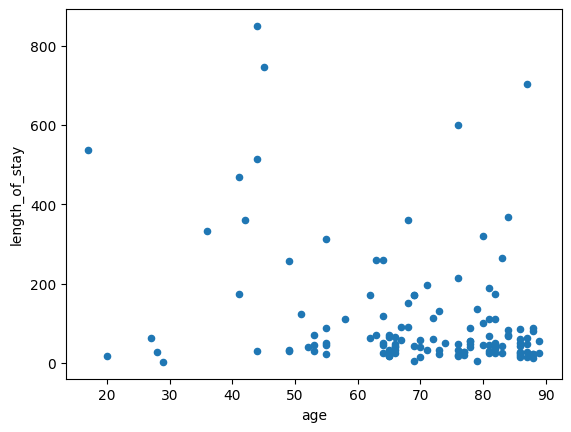

In [13]:
df.plot("age","length_of_stay",kind="scatter")

We see here that there is a concentrated cluster of ICU patients between 50-90 and most patients don't stay for more than 200 hours, but there are some wild outliers to this distribution.

---

**How would you do this in SQL?**

With Ponder, you can work directly with pandas while we run it on your data warehouse for you. 
There's no need to write a single line of SQL. Note that our example draw from [this tutorial](https://mimic.mit.edu/docs/iv/tutorials/bigquery/#tldr) written by MIT researchers who developed MIMIC, here is the equivalent SQL query from the same post:

```sql
WITH re AS (
SELECT
  DATETIME_DIFF(icu.outtime, icu.intime, HOUR) AS icu_length_of_stay,
  DATE_DIFF(DATE(icu.intime), DATE(pat.dob), YEAR) AS age
FROM `physionet-data.mimiciii_demo.icustays` AS icu
INNER JOIN `physionet-data.mimiciii_demo.patients` AS pat
  ON icu.subject_id = pat.subject_id)
SELECT
  age,
  AVG(icu_length_of_stay) AS stay
FROM re
WHERE age < 100
GROUP BY age
ORDER BY age
```

Note that the pandas query is just as easy (if not easier) to write than the SQL query. Moreover, visualization is much more integrated and seamless with Ponder than by working with SQL. 

The [MIMIC tutorial](https://mimic.mit.edu/docs/iv/tutorials/bigquery/#tldr) shows that to plot visualizations in BigQuery you would need to export the data from your Query Editor as a CSV, then the author used Google Sheets to plot the final result. With Ponder, visualization is just a single line of code via pandas's `df.plot` — fully integrated with the rest of your data analysis workflow.

---

Outside of the ICU stay information, we also want to look at the hospital admissions record to understand what happened *before* the patients were admitted to the ICU. 

In [14]:
admissions = pd.read_sql("ADMISSIONS",con=snowflake_con)

Here, we incorporate the admissions table to look at how long the patient stayed at the hospital before they were admitted to the ICU. 

In [15]:
df = df.merge(admissions,on=["hadm_id","subject_id"])

In [16]:
df["pre_icu_length_of_stay"]= (df["intime"]-df["admittime"])/pd.Timedelta('1 day')

By plotting the distribution of pre-ICU length of stay, we learn that most patients were admitted to the ICU within a day of being admitted to the hospital. This reflects the fact that ICU typically caters to patients with severe or life-threatening conditions requiring immediate attention.

Please refer to https://modin.readthedocs.io/en/stable/supported_apis/defaulting_to_pandas.html for explanation.


<Axes: >

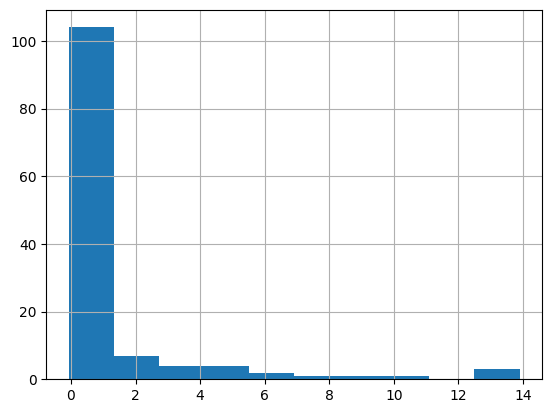

In [17]:
df["pre_icu_length_of_stay"].hist()

In [18]:
print(f"Percentage of ICU admissions within 1 day: \
        {len(df[df['pre_icu_length_of_stay']<1])/len(df)*100:.2f}%")

Percentage of ICU admissions within 1 day:         81.10%


You can find the SQL that performs a similar query on BigQuery in [this tutorial](https://mimic.mit.edu/docs/iii/tutorials/intro-to-mimic-iii-bq/#solution-to-step-4).

### Working with Text: Parsing through clinical diagnosis

Electronic health records can include both structured data (such as clinical measurements of temperature, blood pressure, etc.) and unstructured data (such as imaging, physician notes, etc.). For example, take a look at the [`diagnosis` column](https://mimic.mit.edu/docs/iii/tables/admissions/#diagnosis), which contains free-text diagnosis assigned by the clinician:

In [19]:
df.diagnosis

0                                                 SEPSIS
1                                            HEPATITIS B
2                                                 SEPSIS
3                                       HUMERAL FRACTURE
4                                    ALCOHOLIC HEPATITIS
                             ...                        
122                                  SHORTNESS OF BREATH
123                                 PERICARDIAL EFFUSION
124    ACUTE RESPIRATORY DISTRESS SYNDROME;ACUTE RENA...
125                                          BRADYCARDIA
126                                          CHOLANGITIS
Name: diagnosis, Length: 127, dtype: object

Thankfully, it is easy to work with text data in pandas, since pandas comes with a [convenient set of functions](https://pandas.pydata.org/docs/user_guide/text.html) for operating with string and object type columns. 

Here, we normalize the text by replacing special characters and custom separators with spaces. Then we combine all diagnosis of all the patients together to determine what is the top 5 words that are used in the diagnosis.

In [20]:
df.diagnosis = df.diagnosis.str.replace(";"," ").str.strip()
all_diagnosis_str = df.diagnosis.str.cat(sep=" ")

subs = {"\\":" ", "-":"", "/":"", "?":""}
for s in subs.keys(): 
    all_diagnosis_str = all_diagnosis_str.replace(s, subs[s])

all_diagnosis = all_diagnosis_str.split(" ")

In [21]:
import collections
c = collections.Counter(all_diagnosis)
c.most_common(5)

[('FAILURE', 12), ('SEPSIS', 11), ('PNEUMONIA', 9), ('BLEED', 8), ('ACUTE', 7)]

In [22]:
top_5_keyword = sorted(c, key=c.get, reverse=True)[:5]
print(f"Top 5 most common diagnostic terms are: {top_5_keyword}")

Top 5 most common diagnostic terms are: ['FAILURE', 'SEPSIS', 'PNEUMONIA', 'BLEED', 'ACUTE']


Based on these top five words, we create a binary feature that indicates the presence of each diagnostic term. 

In [23]:
for keyword in top_5_keyword:
    df[keyword]=df['diagnosis'].str.contains(keyword)

### Machine Learning: Mortality prediction of ICU Patients

[Survivial analysis](https://www.nature.com/articles/s41746-022-00679-6) and [mortality prediction](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4321691/) are common use cases by researchers and clinicians for analyzing electronic health data, especially as it pertains to ICU stays.

Now with all the diagnostic features we created, we build a basic machine learning model to predict the likelihood of survival of patients. 

The `hospital_expire_flag` is a binary attribute that captures whether a patient died in the hospital. By printing out the [value counts](https://pandas.pydata.org/docs/reference/api/pandas.Series.value_counts.html) of this attribute, we see that about a third of ICU patients die in the hospital. 

In [24]:
df["hospital_expire_flag"].value_counts()

0    85
1    42
Name: hospital_expire_flag, dtype: int64

We build a binary classification model, where `X` is our features (i.e., presence of diagnostic terms) and `y` is the target (i.e., predict if patient dies in the hospital). 

In [25]:
X = df[top_5_keyword].astype(int)
y = df['hospital_expire_flag']

In [26]:
X

,FAILURE,SEPSIS,PNEUMONIA,BLEED,ACUTE
0,0,1,0,0,0
1,0,0,0,0,0
2,0,1,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0
...,...,...,...,...,...
122,0,0,0,0,0
123,0,0,0,0,0
124,1,0,0,0,1
125,0,0,0,0,0


In [27]:
y

0      0
1      1
2      1
3      0
4      1
      ..
122    0
123    0
124    0
125    0
126    0
Name: hospital_expire_flag, Length: 127, dtype: int8

We split the data into training and test sets. We will hold out 10% of the data for testing the model and use the remaining dataset for training.

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                   test_size= 0.1,random_state=0)

We fit a basic [Naive Bayes classifier](https://scikit-learn.org/stable/modules/naive_bayes.html#naive-bayes) and evaluate the model predictions.

In [29]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train,y_train)

GaussianNB()

In [30]:
predictions = model.predict(X_test)

Here we plot the confusion matrix to show the number of true positives, true negatives, false positives and false negatives.

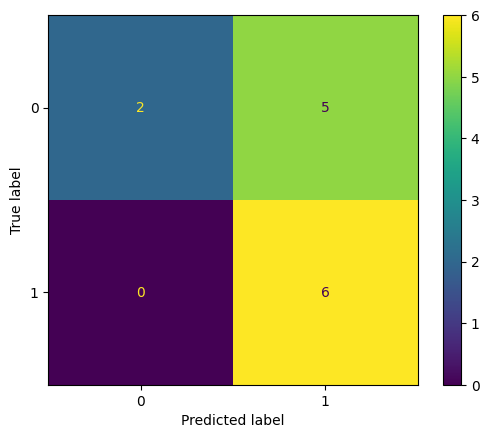

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
disp.plot()

In [32]:
from sklearn.metrics import accuracy_score
score = accuracy_score(y_test, predictions)
print(f'Accuracy of the binary classifier = {score:0.2f}')

Accuracy of the binary classifier = 0.62


Of course, we are working with a very small sample here, so this is mostly intended to be an illustrative example.

**Why use Ponder for healthcare data analysis?**

Now that you've gotten a taste of the types of analysis you could do with Ponder. Let's take a step back and look at why Ponder is an excellent fit for clinicians and healthcare providers looking to perform healthcare data analysis in your data warehouse.

- **It's secure.** Healthcare data analysis often involves working with sensitive Personal Identifiable Health (PIH) data stored securely by the healthcare provider or hospital. Typically, working with pandas requires pulling the data out of the data warehouse before you can work with pandas on your local machine. This increases the risks of data leakage or unauthorized disclosures. With Ponder, all the pandas operations are being pushed down to the warehouse, with the computation happening entirely in the warehouse. This means that IT teams can enforce the same access and security controls as the warehouse.
- **It's scalable.** The volume of healthcare data has been exponential over the past few years and continues to grow. This presents significant opportunities and challenges ahead for health data management. When working with pandas, [scalability bottlenecks related to memory and performance](https://pandas.pydata.org/docs/user_guide/scale.html) often make analyzing large datasets impossible without resorting to big data frameworks such as Spark. With Ponder, you are no longer limited to the confines of in-memory analytics with pandas. Since the computation is happening entirely on the warehouse, Ponder inherits the parallelism and scalability of your warehouse. In fact, we have shown that Ponder works on workloads involving [more than a terabyte of data](https://ponder.io/run-pandas-on-1tb-directly-in-your-data-warehouse/). This is incredibly useful not just for analyzing electronic health records across a large population of patients, but also for large scale genomic analysis, which are often terabyte-scale and more. 
- **It's plain vanilla pandas.** Python is the de facto tool for data science, used by [one in every two software developers](https://ponder.io/pandas-is-now-as-popular-as-python-was-in-2016/) and [more than 90%](https://storage.googleapis.com/kaggle-media/surveys/Kaggle%20State%20of%20Machine%20Learning%20and%20Data%20Science%20Report%202022.pdf) of all data scientists. Among healthcare data practitioners and life scientists, it is also rapidly growing in popularity thanks to the increasing number of [health informatics programs](https://www.coursera.org/specializations/health-informatics) offered by [universities](https://healthinformatics.ucsf.edu/) and [online courses](https://www.coursera.org/specializations/genomic-data-science). Ponder gives you the exact same look-and-feel of pandas, but runnning directly in your warehouse, without requiring you to write a single line of SQL or Spark. Our mission at Ponder is to empower a wider number of domain specialist and practitioners to more easily work with the production-scale data in their warehouse, while sticking with their familiar API. 

### Summary

In this post, we saw how Ponder lets you analyze electronic health records with ease by allowing practitioners to: 
- browse high-level summary and overview of the dataset,
- discover patterns and insights based on visualizations and basic statistics,
- perform date time operations to compute patient's length of stay,
- develop features based on clinician free-text diagnosis,
- build a classification model to predict ICU patient mortality.

Ponder lets you seamlessly move between feature engineering, visualization, and machine learning — all within the Python data ecosystem, while operating directly on the data in your data warehouse. 


Looking to try Ponder on your next healthcare data analysis project? Sign up [here](http://ponder.io/product) to get started in using Ponder!